## Importing Modules

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-07-03 12:23:35.507075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 12:23:35.519844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751525615.532968   44485 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751525615.536490   44485 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751525615.546201   44485 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 🔍 Checking Available Devices

In the following code cell, we list the hardware devices (such as CPUs and GPUs) available to TensorFlow. This check helps confirm whether TensorFlow can access a GPU for faster training or if it will fall back to using the CPU.  
Using the appropriate hardware can significantly improve training performance and reduce training time.


In [2]:
print("Devices available:", tf.config.list_physical_devices())

Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
device="CPU"
if tf.config.list_physical_devices('GPU'):
    device="GPU"

In [4]:
fno0='vocabulary-embedding'

In [5]:
fn1='train'

In [6]:
maxlend=25
maxlenh=25
maxlen=maxlend+maxlenh
rnn_size=512
rnn_layer=3
batch_norm=False


In [7]:
activation_rnn_size=40 if maxlend > 20 else 0

In [8]:
seed = 42
otimizer='adam'
batch_size=64

In [9]:
nb_train_sample=30000
nb_val_sample=3000

In [10]:

df=pd.read_json("data/signalmedia-1m.jsonl/sample-1M.jsonl", lines=True)

In [11]:
df=df.drop(columns=["id","media-type","published","source"])
print(df.head())

                                             content  \
0  VETERANS saluted Worcester's first ever breakf...   
1  New Product Gives Marketers Access to Real Key...   
2  Home »\rStyle » The Return Of The Nike Air Max...   
3  NYMag.com Daily Intelligencer Vulture The Cut ...   
4  KUALA LUMPUR, Sept 15 (MySinchew) -- The Kuala...   

                                               title  
0  Worcester breakfast club for veterans gives hu...  
1  Jumpshot Gives Marketers Renewed Visibility In...  
2  The Return Of The Nike Air Max Sensation Has 8...  
3   This New Dating App Will Ruin Your Internet Game  
4                  Pay up or face legal action: DBKL  


In [12]:
sample = df.head(1)
content_list = df["content"].tolist()
title_list = df["title"].tolist()


print(title_list[0])
print(content_list[0])


Worcester breakfast club for veterans gives hunger its marching orders
VETERANS saluted Worcester's first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. 
 
The Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. 
 
The club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. 
 
Father-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country. 
 
He said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up. 
 
"We even had an old chap travel from Droitwich and he was late on parade by three hours. 
 
"It's generated a lot of interest and I estimate (from other veterans who saw the article) that next month's meeting will attract about 20 people. Onwards 

## Build Vocablury

In [13]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount=Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [14]:
vocal,vocab_count=get_vocab(title_list+content_list)

In [15]:
vocab=list(vocal)
print(vocab[:50])
print(len(vocab))

['the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'with', 'The', 'at', 'as', 'was', 'be', 'are', 'by', 'from', 'have', 'has', 'it', 'will', 'I', 'this', 'an', 'or', 'you', 'not', 'his', 'he', 'their', 'more', 'but', 'said', '-', 'they', 'who', 'we', 'can', 'which', 'its', 'been', 'about', 'all', 'had', 'also', 'our', 'were', 'one']
5456668


Text(0, 0.5, 'total appearances')

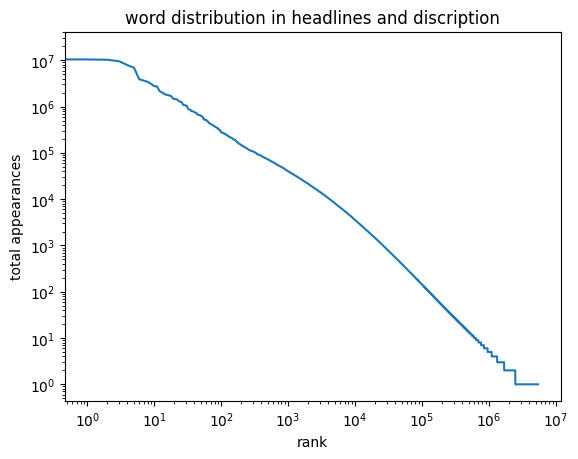

In [16]:
plt.plot([vocab_count[w] for w in vocab])
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances')

## Index Count

In [17]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [18]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [19]:
word2idx, idx2word = get_idx(vocab, vocab_count)

In [20]:
embedding_dim=200

In [ ]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
glove_name=f"data/glove/{fname}"

In [22]:
with open(glove_name, "r", encoding="utf8") as f:
    glove_n_symbols = sum(1 for _ in f)
print(glove_n_symbols)

400000


In [23]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1

In [24]:
glove_embedding_weights.std()

np.float64(0.3818620572721229)

In [25]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## Embeding Matrix

In [26]:
vocab_size=40000

In [27]:
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print ('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.6614044846780933 std 0.3818428118573993
number of tokens, in small vocab, found in glove and copied to embedding 27785 0.694625


In [28]:
glove_thr = 0.5

In [29]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [33]:
normed_embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)

nb_unknown_words = 100
glove_match = []

for w, idx in word2idx.items():
    if idx >= vocab_size - nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx, :].copy()
        gweight /= np.linalg.norm(gweight)
        # Compute cosine similarity in one go
        score = np.dot(normed_embedding[:vocab_size - nb_unknown_words], gweight)
        embedding_idx = np.argmax(score)
        s = score[embedding_idx]
        if s >= glove_thr and idx2word[embedding_idx] in word2glove:
            glove_match.append((w, embedding_idx, s))

glove_match.sort(key=lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 106990


In [34]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.5000101579903996 GUMBO => spicy
0.5000095547771156 Sequoyah => Cherokee
0.5000095547771156 SEQUOYAH => Cherokee
0.5000073940129486 Taim => SunEdison
0.5000073940129486 taim => SunEdison
0.5000071259752128 MME => Madame
0.5000071259752128 Mme => Madame
0.5000071259752128 mme => Madame
0.5000021900878605 Eurocopter => Puma
0.5000018929298966 Rodoljub => SS16


In [35]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

## Data

In [37]:
Y = [[word2idx[token] for token in headline.split()] for headline in title_list]
len(Y)

1000000

In [45]:
X = [[word2idx[token] for token in d.split()] for d in content_list]
len(X)

1000000

In [38]:
FN="vocab-embedding"

In [40]:
import pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [46]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)